## Validate the subdivsion calculation
1. `get_det_subdivs()` function
2. `get_img_subdivs()` function

### Imports

In [1]:
import sys
sys.path.insert(0, '..')
import pymatcal
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

### Read in the configuration from `YAML` file

In [2]:
config = pymatcal.get_config('configs/subdiv_pairs.yml')

### Define $p_A$
- detector unit in focus and the radial distance are read from config file
- Radial distance measures from the detector unit reference frame origin to the FOV center
- detector unit geometry follows the `config.yml` data structure

In [3]:
pointA = np.array([5, 5, 0])
focus_det = config["active det"][0]

### Get subdivisions pairs
- `pAs` are image subdivision centroids
- `pBs` are detector unit subdivision centroids
- `abpairs` determines all subdivision-to-subdivsion rays

In [4]:
det_subdivs = pymatcal.get_det_subdivs(focus_det,config['det nsub'])
# print(det_subdivs['geoms'])
img_subs = pymatcal.get_img_subdivs(config['mmpvx'],config['img nsub'])
pAs = pymatcal.coord_transform(
    pymatcal.get_mtransform(config['angle'], -config['dist'], 5), img_subs['coords']+pointA)
pBs = pymatcal.get_centroids(det_subdivs['geoms'])
abpairs=pymatcal.get_AB_pairs(pAs,pBs)

### Plot $p_A p_B$ subdivision pairs

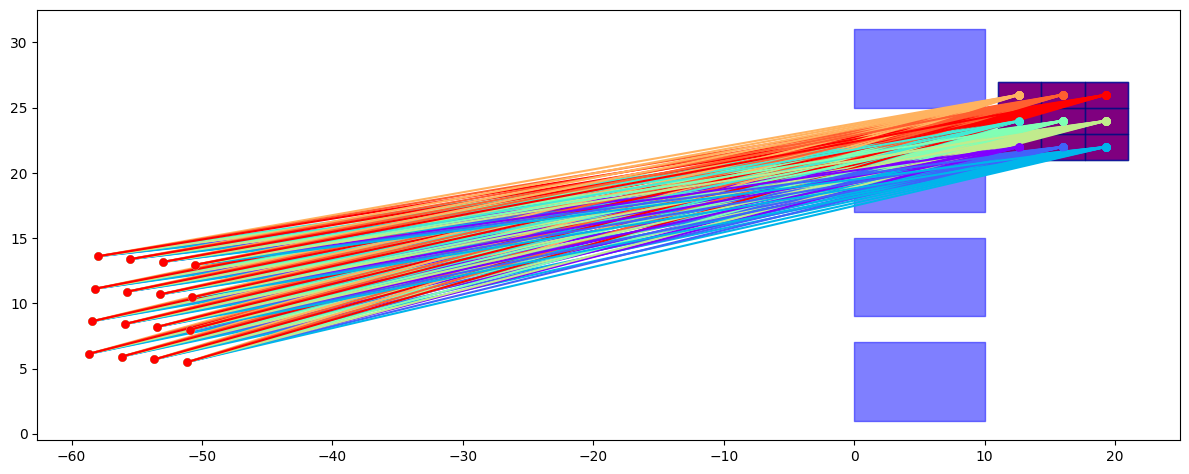

In [5]:
det_list = [
    mpl.patches.Rectangle(
        geom[:3:2],
        geom[1]-geom[0],
        geom[3]-geom[2],
    )
    for geom in config['det geoms']
]
det_subdiv_list = [
    mpl.patches.Rectangle(
        geom[:3:2],
        geom[1]-geom[0],
        geom[3]-geom[2],
    )
    for geom in det_subdivs['geoms']
]
img_subdiv_list = [mpl.patches.Rectangle(
    xy-img_subs['incs'][:2]*0.5, img_subs['incs'][0], img_subs['incs'][1]) for xy in pAs[:, :2]]

fig, ax = plt.subplots(figsize=(12, 10))

pc_subs = mpl.collections.PatchCollection(
    det_subdiv_list, ec=(0, 0.5, 0, 0.5), fc="r")
pc_dets = mpl.collections.PatchCollection(
    det_list, ec=(0, 0, 1, 0.5), fc=(0, 0, 1, 0.5))
pc1 = mpl.collections.PatchCollection(
    det_subdiv_list, ec=(0, 0, 0.5, 0.5), fc='none')
nb = pBs.shape[0]
color = plt.cm.rainbow(np.linspace(0, 1, nb))

idx = 0
for pair in abpairs:
    ax.plot(pair[0::3], pair[1::3], '.-', c=color[idx % nb], ms=10)
    idx += 1


# ax.plot(pointA[0], pointA[1], 'r.', ms=20)

pAs_mins = np.min(pAs, axis=0)
pAs_maxs = np.max(pAs, axis=0)
det_mins = np.min(config["det geoms"], axis=0)
det_maxs = np.max(config["det geoms"], axis=0)
mins = np.min(np.vstack((pAs_mins,det_mins[:6:2])),axis=0)
maxs = np.max(np.vstack((pAs_maxs,det_maxs[1:6:2])),axis=0)
mmdiff=np.abs(maxs-mins)
# ax.set_xlim(mins[0]-mmdiff[0]*0.01,max[0]+mmdiff[0]*0.01)
ax.set_xlim(mins[0]-mmdiff[0]*0.05,maxs[0]+mmdiff[0]*0.05)
ax.set_ylim(mins[1]-mmdiff[1]*0.05,maxs[1]+mmdiff[1]*0.05)
ax.add_collection(pc_subs)
ax.add_collection(pc_dets)
ax.add_collection(pc1)
# ax.add_patch(mpl.patches.Rectangle(
#     (pointA-config['mmpvx']*0.5)[:2], config['mmpvx'][0], config['mmpvx'][1], fc='none', ec='r'))
ax.set_aspect('equal')
fig.tight_layout()
# fig.savefig("get_subdivcoords.png",dpi=300)